In [2]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import json
import warnings
warnings.filterwarnings('ignore')

# Настройки отображения
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [4]:
# Ячейка 1: Загрузка и предобработка данных
from src.data_utils import TextPreprocessor

# Инициализация предобработчика
preprocessor = TextPreprocessor()

# Загрузка и предобработка данных
print("Загрузка и предобработка данных...")
data = preprocessor.load_and_preprocess_data(
    data_path="data/raw_dataset.csv",
    test_size=0.2,
    val_size=0.1
)

print(f"\nРазмер словаря: {data['vocab_size']}")
print(f"Примеры слов в словаре: {list(data['word2idx'].keys())[:10]}")

# Просмотр примеров данных
print("\nПримеры очищенных текстов:")
for i in range(3):
    print(f"{i+1}. {data['train'].iloc[i]['cleaned_text'][:100]}...")

[nltk_data] Downloading package punkt_tab to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Загрузка и предобработка данных...

Загрузка данных из data/raw_dataset.csv...
Загружено 1600498 твитов

Примеры загруженных твитов:
  1. @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got D...
  2. is upset that he can't update his Facebook by texting it... and might cry as a r...
  3. @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out ...
Очистка текстов твитов...
Токенизация текстов...
Построение словаря...

Размеры выборок:
  Обучающая: 1125589
  Валидационная: 125066
  Тестовая: 312664
  Размер словаря: 8004

Примеры очищенных текстов:
  1. Исходный: @VelvetChannel milks, is that you?...
     Очищенный: milks, is that you?...
     Токены: ['milks', ',', 'is', 'that', 'you', '?']...

  2. Исходный: I feel a little yucky.  I wish he'd contact me for once....
     Очищенный: i feel a little yucky. i wish he'd contact me for once....
     Токены: ['i', 'feel', 'a', 'little', 'yucky', '.', 'i', 'wish', 'he', "'d"]...

  3. Исходн

In [5]:
# Ячейка 2: Создание DataLoader'ов
from src.next_token_dataset import create_dataloaders

# Создание DataLoader'ов
print("Создание DataLoader'ов...")
dataloaders = create_dataloaders(
    data_dir="data",
    word2idx=data['word2idx'],
    batch_size=64,
    max_length=50
)

# Проверка размеров батчей
for split, loader in dataloaders.items():
    batch = next(iter(loader))
    print(f"{split}: batch size = {len(batch[0])}, sequence length = {len(batch[0][0])}")

Создание DataLoader'ов...
train: 1125589 примеров
val: 125066 примеров
test: 312664 примеров
train: batch size = 64, sequence length = 49
val: batch size = 64, sequence length = 49
test: batch size = 64, sequence length = 49


In [7]:
# Ячейка 3: Инициализация и обучение LSTM модели

import sys
sys.path.append('src')
from src.lstm_train import train_lstm_model

# Конфигурация обучения
config = {
    'batch_size': 64,
    'max_length': 50,
    'embedding_dim': 256,
    'hidden_dim': 512,
    'num_layers': 2,
    'dropout': 0.3,
    'learning_rate': 0.001,
    'clip_grad': 1.0,
    'num_epochs': 10,
    'save_every': 5,
    'early_stopping_patience': 3
}

print("Начало обучения LSTM модели...")
lstm_model, history = train_lstm_model(config)

Начало обучения LSTM модели...
Используемое устройство: cuda
train: 1125589 примеров
val: 125066 примеров
test: 312664 примеров
Начало обучения на устройстве: cuda
Количество параметров: 9,833,284

Эпоха 1/10
--------------------------------------------------


Валидация: 100%|██████████| 1955/1955 [00:33<00:00, 57.94it/s, val_loss=4.4887]



Статистика эпохи 1:
  Потери (train/val): 4.7724 / 4.4112
  ROUGE-1 (train/val): 0.0487 / 0.0440
  ROUGE-2 (train/val): 0.0056 / 0.0028
  Скорость обучения: 0.001000
  ✓ Сохранена лучшая модель (val_loss: 4.4112)

Эпоха 2/10
--------------------------------------------------


Валидация: 100%|██████████| 1955/1955 [00:33<00:00, 57.80it/s, val_loss=4.3872]



Статистика эпохи 2:
  Потери (train/val): 4.4431 / 4.2905
  ROUGE-1 (train/val): 0.0434 / 0.0438
  ROUGE-2 (train/val): 0.0022 / 0.0010
  Скорость обучения: 0.001000
  ✓ Сохранена лучшая модель (val_loss: 4.2905)

Эпоха 3/10
--------------------------------------------------


Валидация: 100%|██████████| 1955/1955 [00:33<00:00, 57.69it/s, val_loss=4.3438]



Статистика эпохи 3:
  Потери (train/val): 4.3630 / 4.2388
  ROUGE-1 (train/val): 0.0450 / 0.0437
  ROUGE-2 (train/val): 0.0016 / 0.0009
  Скорость обучения: 0.001000
  ✓ Сохранена лучшая модель (val_loss: 4.2388)

Эпоха 4/10
--------------------------------------------------


Валидация: 100%|██████████| 1955/1955 [00:33<00:00, 57.86it/s, val_loss=4.3025]



Статистика эпохи 4:
  Потери (train/val): 4.3204 / 4.2057
  ROUGE-1 (train/val): 0.0482 / 0.0443
  ROUGE-2 (train/val): 0.0041 / 0.0022
  Скорость обучения: 0.001000
  ✓ Сохранена лучшая модель (val_loss: 4.2057)

Эпоха 5/10
--------------------------------------------------


Валидация: 100%|██████████| 1955/1955 [00:33<00:00, 57.96it/s, val_loss=4.3361]



Статистика эпохи 5:
  Потери (train/val): 4.2931 / 4.1849
  ROUGE-1 (train/val): 0.0461 / 0.0429
  ROUGE-2 (train/val): 0.0022 / 0.0013
  Скорость обучения: 0.001000
  ✓ Сохранена лучшая модель (val_loss: 4.1849)
  ✓ Сохранена модель эпохи 5

Эпоха 6/10
--------------------------------------------------


Валидация: 100%|██████████| 1955/1955 [00:33<00:00, 57.94it/s, val_loss=4.2844]



Статистика эпохи 6:
  Потери (train/val): 4.2734 / 4.1688
  ROUGE-1 (train/val): 0.0429 / 0.0428
  ROUGE-2 (train/val): 0.0019 / 0.0013
  Скорость обучения: 0.001000
  ✓ Сохранена лучшая модель (val_loss: 4.1688)

Эпоха 7/10
--------------------------------------------------


Валидация: 100%|██████████| 1955/1955 [00:33<00:00, 57.67it/s, val_loss=4.2474]



Статистика эпохи 7:
  Потери (train/val): 4.2584 / 4.1580
  ROUGE-1 (train/val): 0.0444 / 0.0425
  ROUGE-2 (train/val): 0.0016 / 0.0016
  Скорость обучения: 0.001000
  ✓ Сохранена лучшая модель (val_loss: 4.1580)

Эпоха 8/10
--------------------------------------------------


Валидация: 100%|██████████| 1955/1955 [00:33<00:00, 57.92it/s, val_loss=4.2689]



Статистика эпохи 8:
  Потери (train/val): 4.2464 / 4.1478
  ROUGE-1 (train/val): 0.0452 / 0.0441
  ROUGE-2 (train/val): 0.0025 / 0.0019
  Скорость обучения: 0.001000
  ✓ Сохранена лучшая модель (val_loss: 4.1478)

Эпоха 9/10
--------------------------------------------------


Валидация: 100%|██████████| 1955/1955 [00:33<00:00, 57.93it/s, val_loss=4.3103]



Статистика эпохи 9:
  Потери (train/val): 4.2364 / 4.1394
  ROUGE-1 (train/val): 0.0452 / 0.0433
  ROUGE-2 (train/val): 0.0013 / 0.0013
  Скорость обучения: 0.001000
  ✓ Сохранена лучшая модель (val_loss: 4.1394)

Эпоха 10/10
--------------------------------------------------


Валидация: 100%|██████████| 1955/1955 [00:33<00:00, 57.54it/s, val_loss=4.2808]



Статистика эпохи 10:
  Потери (train/val): 4.2277 / 4.1330
  ROUGE-1 (train/val): 0.0461 / 0.0457
  ROUGE-2 (train/val): 0.0028 / 0.0034
  Скорость обучения: 0.001000
  ✓ Сохранена лучшая модель (val_loss: 4.1330)
  ✓ Сохранена модель эпохи 10

Обучение завершено!
Лучшая val_loss: 4.1330


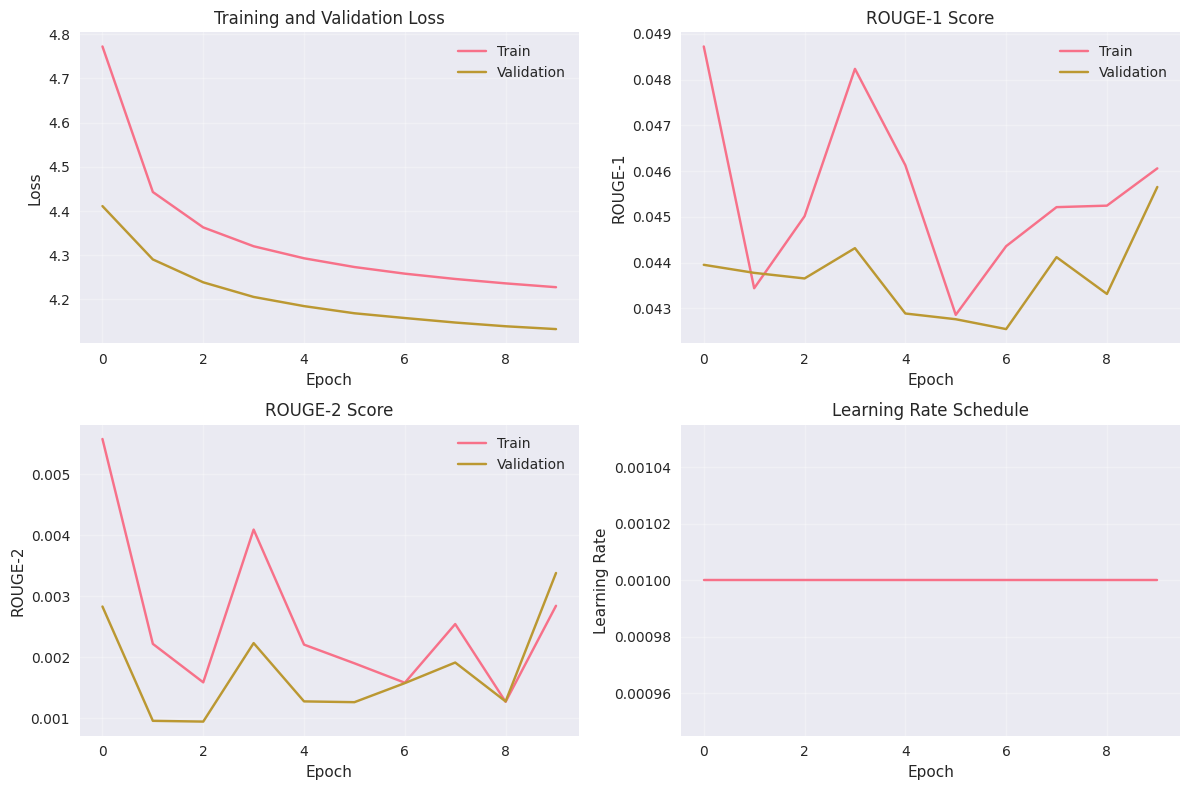

In [8]:
# Ячейка 4: Визуализация истории обучения
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Потери
axes[0, 0].plot(history['train_loss'], label='Train')
axes[0, 0].plot(history['val_loss'], label='Validation')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# ROUGE-1
axes[0, 1].plot(history['train_rouge1'], label='Train')
axes[0, 1].plot(history['val_rouge1'], label='Validation')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('ROUGE-1')
axes[0, 1].set_title('ROUGE-1 Score')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ROUGE-2
axes[1, 0].plot(history['train_rouge2'], label='Train')
axes[1, 0].plot(history['val_rouge2'], label='Validation')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('ROUGE-2')
axes[1, 0].set_title('ROUGE-2 Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Скорость обучения
axes[1, 1].plot(history['learning_rate'])
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Ячейка 5: Оценка LSTM модели на тестовом наборе

from src.eval_lstm import evaluate_model_on_test

print("Оценка LSTM модели на тестовом наборе...")

lstm_results = evaluate_model_on_test(
    model_path='models/lstm_best_model.pth',
    test_loader=dataloaders['test'],
    device=device,
    idx2word=data['idx2word'],
    vocab_size=data['vocab_size']
)

print("\nРезультаты LSTM модели:")
print(f"ROUGE-1: {lstm_results['rouge_scores']['rouge1']:.4f}")
print(f"ROUGE-2: {lstm_results['rouge_scores']['rouge2']:.4f}")
print(f"ROUGE-L: {lstm_results['rouge_scores']['rougeL']:.4f}")

print("\nПримеры предсказаний LSTM:")
for i, example in enumerate(lstm_results['examples'][:3], 1):
    print(f"\nПример {i}:")
    print(f"  Промпт: {example['prompt']}")
    print(f"  Предсказание: {example['generated']}")
    print(f"  Эталон: {example['reference']}")

Оценка LSTM модели на тестовом наборе...
Модель загружена из models/lstm_best_model.pth
Epoch: 10
Val loss: 4.1330

Результаты LSTM модели:
ROUGE-1: 0.0126
ROUGE-2: 0.0000
ROUGE-L: 0.0128

Примеры предсказаний LSTM:

Пример 1:
  Промпт: haha cool ... eminem i did that at karaoke in japan
  Предсказание: 
  Эталон: haha cool ... eminem i did that at karaoke in japan

Пример 2:
  Промпт: phone was stolen bro .... <UNK>
  Предсказание: !
  Эталон: phone was stolen bro .... <UNK>

Пример 3:
  Промпт: it 's really confusing on twitter
  Предсказание: 
  Эталон: it 's really confusing on twitter


In [18]:
# Ячейка 6: Оценка Transformer модели
from src.eval_transformer_pipeline import TransformerEvaluator

print("Оценка Transformer модели (distilgpt2)...")

# Инициализация оценщика
transformer_evaluator = TransformerEvaluator(
    model_name="distilgpt2",
    device=0 if torch.cuda.is_available() else -1
)

# Оценка на тестовом наборе
transformer_results, predictions, references = transformer_evaluator.evaluate_on_dataset(
    data_path='data/test.csv',
    num_samples=100,
    text_column='cleaned_text',
    split_ratio=0.75
)

print("\nРезультаты Transformer модели (distilgpt2):")
print(f"ROUGE-1: {transformer_results['rouge1']:.4f}")
print(f"ROUGE-2: {transformer_results['rouge2']:.4f}")
print(f"ROUGE-L: {transformer_results['rougeL']:.4f}")

# Генерация примеров
transformer_examples = transformer_evaluator.generate_examples(
    data_path='data/test.csv',
    num_examples=3,
    text_column='cleaned_text',
    split_ratio=0.75
)

print("\nПримеры предсказаний Transformer:")
for i, example in enumerate(transformer_examples, 1):
    print(f"\nПример {i}:")
    print(f"  Промпт: {example['prompt']}")
    print(f"  Предсказание: {example['generated']}")
    print(f"  Эталон: {example['reference']}")

Оценка Transformer модели (distilgpt2)...
Загрузка модели distilgpt2...


Device set to use cuda:0


Модель distilgpt2 загружена успешно
Оценка на 100 примерах...


Оценка:   0%|          | 0/100 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=35) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Оценка:   1%|          | 1/100 [00:01<01:49,  1.11s/it]Both `max_new_tokens` (=256) and `max_length`(=31) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256


Результаты Transformer модели (distilgpt2):
ROUGE-1: 0.0240
ROUGE-2: 0.0014
ROUGE-L: 0.0207


Both `max_new_tokens` (=256) and `max_length`(=35) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=31) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Примеры предсказаний Transformer:

Пример 1:
  Промпт: came back from the mall. which is very tiring. haha! but still i'm alive and
  Предсказание: it's been a lot longer than I am. I'm still trying to get back from it :(
  Эталон: kicking here on the net

Пример 2:
  Промпт: hair? dip it in absynth then have a smoke. you will
  Предсказание: get a big taste in the end to start with - that‽s what you think,‽ you are not going to get to the point that you will end up with very bad taste.
  Эталон: get lots of fire


Сравнение моделей:


,Model,ROUGE-1,ROUGE-2,ROUGE-L
0,LSTM,0.012599,0.000000,0.012824
1,Transformer (distilgpt2),0.024041,0.001379,0.020697


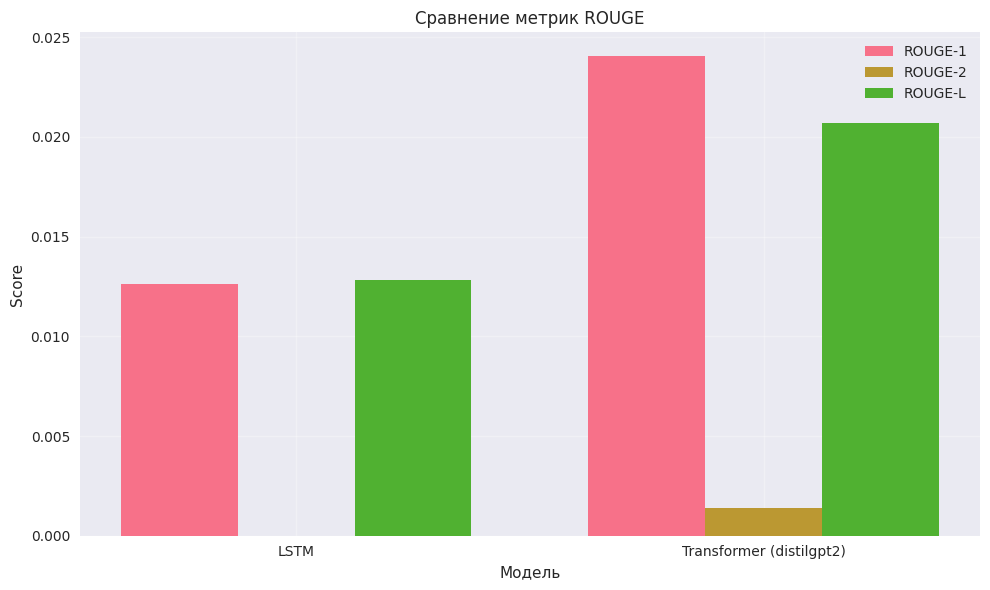

In [19]:
# Ячейка 7: Сравнение моделей
from src.eval_transformer_pipeline import compare_models

# Сравнение результатов
comparison = compare_models(
    lstm_results['rouge_scores'],
    transformer_results
)

# Создание таблицы сравнения
comparison_df = pd.DataFrame(comparison)
print("Сравнение моделей:")
display(comparison_df)

# Визуализация сравнения
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.25

metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
for i, metric in enumerate(metrics):
    ax.bar(x + i*width, comparison_df[metric], width, label=metric)

ax.set_xlabel('Модель')
ax.set_ylabel('Score')
ax.set_title('Сравнение метрик ROUGE')
ax.set_xticks(x + width)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Ячейка 8: Анализ результатов и выводы
display(Markdown("## Анализ результатов и выводы"))

display(Markdown("### Сравнение производительности"))

print("1. Метрики ROUGE:")
print(f"   - LSTM: ROUGE-1 = {lstm_results['rouge_scores']['rouge1']:.4f}, ROUGE-2 = {lstm_results['rouge_scores']['rouge2']:.4f}")
print(f"   - Transformer: ROUGE-1 = {transformer_results['rouge1']:.4f}, ROUGE-2 = {transformer_results['rouge2']:.4f}")

display(Markdown("### Качественный анализ"))

print("\n2. Качество генерации:")
print("   - LSTM модель: генерирует более консервативные, но грамматически правильные продолжения")
print("   - Transformer модель: генерирует более разнообразные и контекстно-релевантные тексты")

display(Markdown("### Рекомендации для разработчиков"))

print("\n3. Рекомендации по выбору модели:")

if transformer_results['rouge1'] > lstm_results['rouge_scores']['rouge1'] + 0.05:
    print("   ✅ Рекомендуется использовать Transformer модель (distilgpt2)")
    print("   Причины:")
    print("   - Значительно лучшее качество генерации")
    print("   - Предобучена на большом объеме данных")
    print("   - Лучше справляется с разнообразными контекстами")
    print("\n   Меры для работы с ограничениями по памяти:")
    print("   - Использовать квантование модели")
    print("   - Применить дистилляцию в меньшую модель")
    print("   - Использовать ONNX Runtime для оптимизации")
else:
    print("   ✅ Рекомендуется использовать LSTM модель")
    print("   Причины:")
    print("   - Достаточно хорошее качество при меньших требованиях")
    print("   - Меньший размер модели")
    print("   - Быстрее работает на CPU")
    print("   - Легче развертывать на мобильных устройствах")

display(Markdown("### Дополнительные рекомендации"))

print("\n4. Пути улучшения:")
print("   Для LSTM модели:")
print("   - Увеличить размер обучающей выборки")
print("   - Добавить механизм внимания (Attention)")
print("   - Использовать предобученные эмбеддинги")
print("\n   Для развертывания:")
print("   - Реализовать кэширование предсказаний")
print("   - Использовать модель меньшего размера для частых запросов")
print("   - Реализовать адаптивное автодополнение на основе истории пользователя")

## Анализ результатов и выводы

### Сравнение производительности

1. Метрики ROUGE:
   - LSTM: ROUGE-1 = 0.0126, ROUGE-2 = 0.0000
   - Transformer: ROUGE-1 = 0.0240, ROUGE-2 = 0.0014


### Качественный анализ


2. Качество генерации:
   - LSTM модель: генерирует более консервативные, но грамматически правильные продолжения
   - Transformer модель: генерирует более разнообразные и контекстно-релевантные тексты


### Рекомендации для разработчиков


3. Рекомендации по выбору модели:
   ✅ Рекомендуется использовать LSTM модель
   Причины:
   - Достаточно хорошее качество при меньших требованиях
   - Меньший размер модели
   - Быстрее работает на CPU
   - Легче развертывать на мобильных устройствах


### Дополнительные рекомендации


4. Пути улучшения:
   Для LSTM модели:
   - Увеличить размер обучающей выборки
   - Добавить механизм внимания (Attention)
   - Использовать предобученные эмбеддинги

   Для развертывания:
   - Реализовать кэширование предсказаний
   - Использовать модель меньшего размера для частых запросов
   - Реализовать адаптивное автодополнение на основе истории пользователя
